In [362]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [363]:
df=pd.read_csv('topics.csv', on_bad_lines='skip')

In [364]:
df.shape

(18775, 2)

In [365]:
df.head(10)

,text,label
0,"Y'all lighten up on Harry, Skip'll be like tha...",rec.sport.baseball
1,\nIt depends on the cause of the pneumonia. F...,sci.med
2,\nThere is a wonderful book by Jean Meeus call...,sci.space
3,"\n\n\nNo, you have completely misunderstood. ...",talk.politics.mideast
4,\nThat's not true. I gave you two examples....,alt.atheism
5,\nAbout a month ago there was a photo posted o...,sci.electronics
6,Thanks to all those people who recommended Wor...,comp.os.ms-windows.misc
7,\nYou are making precisely one of the points I...,sci.med
8,\n\tDoes anyone have details on this? What s...,comp.sys.mac.hardware
9,"While there are too many PS clones to count, s...",comp.os.ms-windows.misc


In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18775 entries, 0 to 18774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18396 non-null  object
 1   label   18748 non-null  object
dtypes: object(2)
memory usage: 293.5+ KB


In [367]:
df=df.dropna(how='any')
df=df.drop_duplicates()

In [368]:
df['label'].value_counts()

label
soc.religion.christian                                                                                                                                                                                                                                                                                                                                                                                                                                 978
rec.sport.hockey                                                                                                                                                                                                                                                                                                                                                                                                                                       978
rec.motorcycles                                                                                             

In [369]:
df=df[df['label'].str.startswith(('soc.','rec.','comp.','sci.','misc.','talk.','alt.'))]

In [370]:
df['label'].value_counts()

label
rec.sport.hockey            978
soc.religion.christian      978
rec.motorcycles             971
comp.sys.ibm.pc.hardware    967
sci.crypt                   964
rec.sport.baseball          962
sci.med                     962
comp.windows.x              958
sci.space                   955
comp.graphics               954
sci.electronics             954
comp.os.ms-windows.misc     949
misc.forsale                945
rec.autos                   937
comp.sys.mac.hardware       931
talk.politics.mideast       911
talk.politics.guns          887
alt.atheism                 769
talk.politics.misc          711
talk.religion.misc          598
Name: count, dtype: int64

In [371]:
df.shape

(18241, 2)

In [372]:
df.nunique()

text     18176
label       20
dtype: int64

In [373]:
df=df.drop_duplicates(subset='text')

In [374]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [338]:
def clean_text(text):
    text=re.sub(r'(?im)^(from|date|message-id|sender|organization|expires|reply-to|distribution|keywords|newsgroups|references|lines)[:\-].*$','',text)
    text=re.sub(r'\S+@\S+',' ',text)
    text= re.sub(r'[^a-zA-Z]'," ",text)
    text=text.lower()
    text=re.sub(r'\s+'," ",text)
    text=' '.join([word for word in text.split() if len(word)>2])
    text=' '.join([word for word in text.split() if word not in stop_words])

    return text
    

In [339]:
words_count_before_cleaning=df['text'].str.split().apply(len).sum()
print('Number of words before cleaning:',words_count_before_cleaning)
df['text']=df['text'].apply(clean_text)
df=df[df['text'].str.strip() != '']
df.to_csv('df.csv', index=False)
words_count_after_cleaning=df['text'].str.split().apply(len).sum()
print("Number of words after cleaning:",words_count_after_cleaning)

Number of words before cleaning: 3376036
Number of words after cleaning: 1703803


In [ ]:
from collections import Counter

In [ ]:
all_texts=' '.join(df['text'])
words=all_texts.split()
words_counter= Counter(words)
top_20_words=words_counter.most_common(20)
print("Top 20 most occurring words:")
for word, count in top_20_words:
    print(word,": ",count)

In [341]:
df.shape

(18121, 2)

#### Logistic regression

In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [343]:
X_train, X_test, y_train, y_test=train_test_split(df['text'],df['label'],test_size=0.2,random_state=42,stratify=df['label'])

In [344]:
vectorizer=TfidfVectorizer()
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)

In [ ]:
model=LogisticRegression(max_iter=1000)
model.fit(X_train_vec,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred=model.predict(X_test_vec)
print(classification_report(y_test,y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.61      0.62       153
           comp.graphics       0.67      0.78      0.72       189
 comp.os.ms-windows.misc       0.75      0.66      0.70       189
comp.sys.ibm.pc.hardware       0.70      0.73      0.72       192
   comp.sys.mac.hardware       0.82      0.69      0.75       185
          comp.windows.x       0.83      0.80      0.81       191
            misc.forsale       0.84      0.84      0.84       188
               rec.autos       0.80      0.79      0.80       186
         rec.motorcycles       0.71      0.81      0.76       193
      rec.sport.baseball       0.90      0.88      0.89       190
        rec.sport.hockey       0.95      0.89      0.91       194
               sci.crypt       0.86      0.80      0.83       192
         sci.electronics       0.64      0.76      0.69       190
                 sci.med       0.81      0.90      0.85       191
         

#### Naive Bayes

In [347]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model= MultinomialNB()
model.fit(X_train_vec,y_train)

MultinomialNB()

In [ ]:
y_pred=model.predict(X_test_vec)
print(classification_report(y_test,y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.26      0.39       153
           comp.graphics       0.67      0.72      0.69       189
 comp.os.ms-windows.misc       0.77      0.65      0.70       189
comp.sys.ibm.pc.hardware       0.57      0.81      0.67       192
   comp.sys.mac.hardware       0.84      0.72      0.78       185
          comp.windows.x       0.84      0.80      0.82       191
            misc.forsale       0.88      0.77      0.82       188
               rec.autos       0.85      0.74      0.79       186
         rec.motorcycles       0.87      0.74      0.80       193
      rec.sport.baseball       0.95      0.84      0.89       190
        rec.sport.hockey       0.86      0.92      0.89       194
               sci.crypt       0.62      0.89      0.73       192
         sci.electronics       0.81      0.71      0.75       190
                 sci.med       0.92      0.85      0.88       191
         

#### ANN:

In [350]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [351]:
le= LabelEncoder()
df['encoded_label']=le.fit_transform(df['label'])

In [352]:
max_words=10000
max_len=100
embedding_dim=64
tokenizer= Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences= tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
X=pad_sequences(sequences,maxlen=max_len)
y=to_categorical(df['encoded_label'])

In [353]:
X_train1, X_test, y_train1, y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=df['encoded_label'])
X_train, X_val, y_train, y_val= train_test_split(X_train1,y_train1,test_size=0.1,random_state=42,stratify=y_train1)

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=max_words,output_dim=embedding_dim,input_length=max_len))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.build(input_shape=(None, 100))

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [355]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,964 (4.01 MB)

 Trainable params: 1,050,964 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [356]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [357]:
callbacks=[
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='best_checkpoint.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3
    )
]

In [ ]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    epochs=100,
    batch_size=128,
    #callbacks=callbacks,
    verbose=2)

Epoch 1/100
102/102 - 6s - 54ms/step - accuracy: 0.1049 - loss: 2.8901 - val_accuracy: 0.1800 - val_loss: 2.5854 - learning_rate: 1.0000e-03
Epoch 2/100
102/102 - 2s - 23ms/step - accuracy: 0.4521 - loss: 1.8971 - val_accuracy: 0.5200 - val_loss: 1.6100 - learning_rate: 1.0000e-03
Epoch 3/100
102/102 - 2s - 21ms/step - accuracy: 0.7549 - loss: 0.9587 - val_accuracy: 0.6021 - val_loss: 1.3253 - learning_rate: 1.0000e-03
Epoch 4/100
102/102 - 2s - 20ms/step - accuracy: 0.8764 - loss: 0.5403 - val_accuracy: 0.6393 - val_loss: 1.2292 - learning_rate: 1.0000e-03
Epoch 5/100
102/102 - 2s - 21ms/step - accuracy: 0.9348 - loss: 0.3283 - val_accuracy: 0.6152 - val_loss: 1.2927 - learning_rate: 1.0000e-03
Epoch 6/100
102/102 - 2s - 19ms/step - accuracy: 0.9635 - loss: 0.2046 - val_accuracy: 0.6228 - val_loss: 1.2974 - learning_rate: 1.0000e-03
Epoch 7/100
102/102 - 2s - 19ms/step - accuracy: 0.9765 - loss: 0.1382 - val_accuracy: 0.6207 - val_loss: 1.3374 - learning_rate: 1.0000e-03
Epoch 8/100
1

In [ ]:
results=model.evaluate(X_test,y_test,verbose=1)
print('Test loss:',results[0])
print('Test accuracy;',results[1])


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6307 - loss: 1.2316
Test loss: 1.2160531282424927
Test accuracy; 0.6336551904678345


In [ ]:
y_pred_prob=model.predict(X_test)
y_pred=np.argmax(y_pred_prob,axis=1)
y_test_labels = np.argmax(y_test, axis=1)
labels_names=le.classes_
print(classification_report(y_test_labels, y_pred, target_names=labels_names))

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
                          precision    recall  f1-score   support

             alt.atheism       0.53      0.42      0.47       153
           comp.graphics       0.57      0.59      0.58       189
 comp.os.ms-windows.misc       0.62      0.59      0.60       189
comp.sys.ibm.pc.hardware       0.63      0.54      0.58       192
   comp.sys.mac.hardware       0.65      0.58      0.61       185
          comp.windows.x       0.75      0.71      0.73       191
            misc.forsale       0.81      0.66      0.73       188
               rec.autos       0.57      0.68      0.62       186
         rec.motorcycles       0.45      0.75      0.56       193
      rec.sport.baseball       0.77      0.80      0.78       190
        rec.sport.hockey       0.96      0.74      0.84       194
               sci.crypt       0.85      0.64      0.73       192
         sci.electronics       0.61      0.57      0.59       190
                 sci.med       0.7

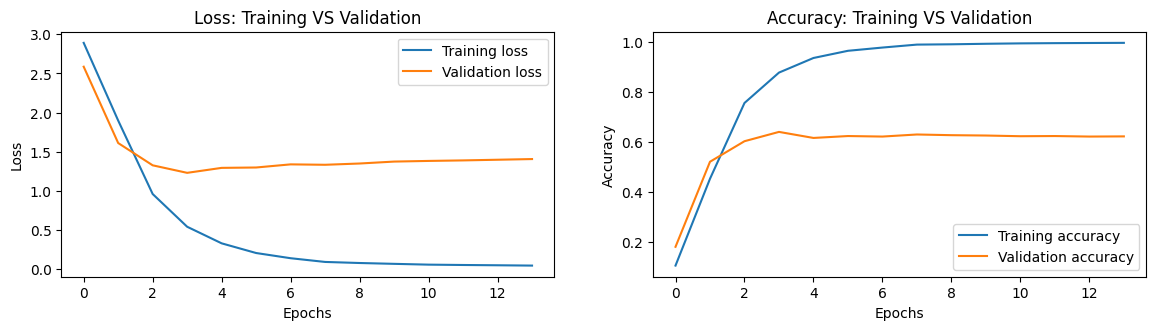

In [ ]:
plt.figure(figsize=(14,7))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss: Training VS Validation')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy: Training VS Validation')
plt.legend()

plt.show()